In [96]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
%config IPCompleter.greedy=True

In [97]:
df = pd.read_csv('avocado.csv', index_col = 'Date')

In [98]:
#Let's print the head to get a feeling for the data
df = df.sort_index()
df.head()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,,
2015-01-04,51,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
2015-01-04,51,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2015-01-04,51,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
2015-01-04,51,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
2015-01-04,51,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


# Initial Impressions

Well we can clearly see there is a bit of cleaning left to do. Luckily the dataset downloaded explicitly stated there were no missing values so we don't have to worry about those. There is an Unnamed: 0 column floating in the dataset that seems to have no meaning whatsoever. The 4046-4770 columns should be renamed to more clearly show what the variable actually represents: avocado sizes. Finally, we should add month, day, and season features to increase the amount of data our model will have to work with. So let's write a custom transformer using sci-kit learn to wrap all the initial operations into a neat little package.

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin
class InitialManipulation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def transform(self, X, y = None):
        X['month'] = pd.to_datetime(X.index)
        X['month'] = X['month'].dt.month
        X['day'] = pd.to_datetime(X.index)
        X['day'] = X['day'].dt.day
        X['Season'] = pd.to_datetime(X.index)
        X['Season'] = (X['Season'].dt.month%12 + 3) // 3
        X = X.drop(columns = ['Unnamed: 0'])
        X = X.rename(columns={'4046': 'Small Avocados Sold', '4225': 'Medium Avocados Sold', 
                                '4770': 'Large Avocados Sold'})
        X = X.reset_index()
        return X

In [100]:
transformer = InitialManipulation()
df = transformer.transform(df)

#creating the label set
Y = df['AveragePrice'].copy()
df = df.drop(columns=['AveragePrice'])

In [101]:
df.head()

,Date,Total Volume,Small Avocados Sold,Medium Avocados Sold,Large Avocados Sold,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,day,Season
0,2015-01-04,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,1,4,1
1,2015-01-04,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,1,4,1
2,2015-01-04,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,1,4,1
3,2015-01-04,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,1,4,1
4,2015-01-04,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,1,4,1


# Further Pre-processing

Now that the dataset has been cleaned up and augmented. We are going to need further process the data before it is able to be properly input into a machine learning model. Categorical variables such as month, day, year, and Season would only need to be scaled with all the other numerical variables. Scaling the values helps the model train faster and not accidentally bias the model towards one feature or another. These categorical variables are special and can remain as integers because the relationship in the distance between numbers is accurate for the distance between each category i.e. January is close to February same way 1 is close to 2. However, the region and type variables cannot be processed that way since New York is generally going to be independent from Chicago so representing them with integers may confuse the model to find proximity relationships that don't exist. We are going to need to one-hot encode those.

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

df_date = df['Date']
df = df.drop(columns = ['Date'])
df_numerical = df.copy().drop(columns = ['type', 'region'])
df_categorical = df[['type', 'region']]

categorical_columns = list(df_categorical)

scaler = MinMaxScaler()
encoder = OneHotEncoder()
df_numerical = scaler.fit_transform(df_numerical)
df_numerical = pd.DataFrame(df_numerical)
df_numerical = pd.concat([df_numerical, df_date], axis = 1)

In [103]:
df_categorical = pd.get_dummies(df_categorical, sparse = True)

In [104]:
df_concat = pd.concat([df_numerical, df_categorical], axis = 1)

# Randomizing the dataset

It is generally the best practice to randomize the split between the training set and the testing set so that there are less possible statistical biases that the model can pick up on. We are going to reserve the test set at the very end for final evaluation of the model.

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_concat, Y, test_size = .2, random_state = 42)

df_date = X_test['Date']
X_train = X_train.drop(columns = ['Date'])
X_test = X_test.drop(columns = ['Date'])

In [106]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Evaluating the model

Training the model was incredibly simple thanks to the scikit-learn API. Now we need to see whether all this work was worth the trouble. First off, you may have noticed initially that our dataset has quite a few duplicate dates within the index. That is because the dataset contains prices for every single region/city on a specifc day. In order to properly evaluate the model and make sense of the later graph, we are just going to extract all datapoints on Chicago from our test set. The city doesn't matter as long as we just use one.

In [107]:
chicago = X_test[X_test['region_Chicago'] == 1]
df_date = df_date[chicago.index]

chicago_labels = Y_test[chicago.index]
chicago_labels = pd.concat([chicago_labels, df_date], axis = 1)

chicago_labels = chicago_labels.set_index(chicago_labels['Date'])
chicago_labels = chicago_labels.drop(columns = ['Date'])

preds = model.predict(chicago)
preds = pd.DataFrame(preds, index = df_date)

preds = preds.sort_index()
chicago_labels = chicago_labels.sort_index()

In [108]:
from sklearn.metrics import mean_squared_error

#error metric of our model
error = mean_squared_error(preds, chicago_labels)
print(error)

0.030257757575757573


In [109]:
import matplotlib.pyplot as plt

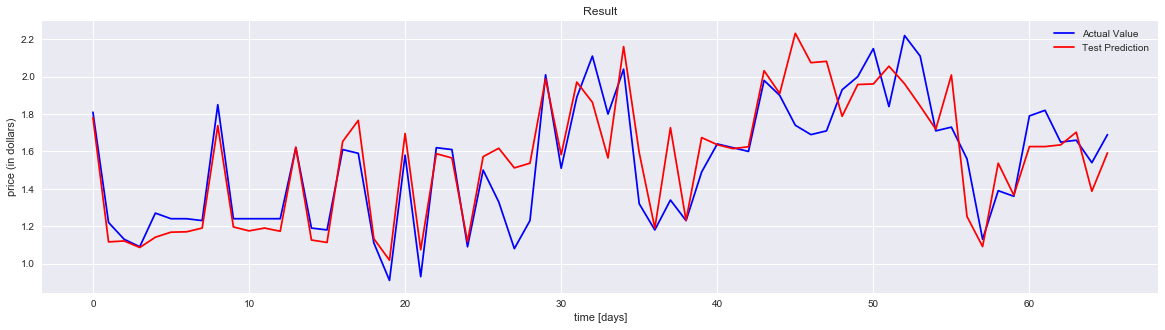

In [110]:
plt.style.use('seaborn')
plt.figure(figsize=(20, 5))
plt.subplot(1,1,1)
plt.plot(np.array(chicago_labels), color='blue', label='Actual Value')
plt.plot(np.array(preds),color='red',label='Test Prediction')
plt.title('Result')
plt.xlabel('time [days]')
plt.ylabel('price (in dollars)')
plt.legend(loc='best')
plt.show()

# Final Thoughts

The model performed fairly decently. There is definitely room for improvement as one can see from the graph. The later values tended to be very poorly fit compared to the intial half of the graph. We could use GridSearchCV and maybe find additional datasets such as climate to further improve model accuracy. But for now, we can appreciate the results.